<a href="https://colab.research.google.com/github/yoomhub/LSTM_Applications/blob/master/Time-to-Event%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Survival Analysis Using Recurrent Neural Networks

This notebook is utilizing Deep Recurrent Survival Analysis (DRSA) based on [Ren et al. (2019)](https://arxiv.org/abs/1809.02403).

---

### Seongyoon Kim

Department of Computational Science and Engineering

20191009

---


## 1. Import Libraries



In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import seaborn as sns

!pip install lifelines

from lifelines.datasets import load_rossi

TensorFlow 2.x selected.


In [2]:
!pip install keras-rectified-adam
from keras_radam.training import RAdamOptimizer

Using TensorFlow backend.


## 2. Read Data

This dataset is the Rossi recidivism dataset, available in [lifelines](https://lifelines.readthedocs.io/en/latest/index.html) as `load_rossi()`.

The dataframe `rossi` contains 432 observations. The week column is the duration, the arrest column is the event occurred, and the other columns represent variables we wish to regress against.

In [3]:
df = load_rossi().astype(float)

df.head(10)

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20.0,1.0,0.0,27.0,1.0,0.0,0.0,1.0,3.0
1,17.0,1.0,0.0,18.0,1.0,0.0,0.0,1.0,8.0
2,25.0,1.0,0.0,19.0,0.0,1.0,0.0,1.0,13.0
3,52.0,0.0,1.0,23.0,1.0,1.0,1.0,1.0,1.0
4,52.0,0.0,0.0,19.0,0.0,1.0,0.0,1.0,3.0
5,52.0,0.0,0.0,24.0,1.0,1.0,0.0,0.0,2.0
6,23.0,1.0,0.0,25.0,1.0,1.0,1.0,1.0,0.0
7,52.0,0.0,1.0,21.0,1.0,1.0,0.0,1.0,4.0
8,52.0,0.0,0.0,22.0,1.0,0.0,0.0,0.0,6.0
9,52.0,0.0,0.0,20.0,1.0,1.0,0.0,0.0,0.0


In [4]:
df.shape

(432, 9)

Check whether the missing values exist.

In [5]:
df.isna().sum(0)[df.isna().sum(0)>0]

Series([], dtype: int64)

## 3. Data Preprocessing

In [6]:
event_data = df.pop('arrest')
dtime_data = df.pop('week')
print(event_data.head(10))
print(dtime_data.head(10))

0    1.0
1    1.0
2    1.0
3    0.0
4    0.0
5    0.0
6    1.0
7    0.0
8    0.0
9    0.0
Name: arrest, dtype: float64
0    20.0
1    17.0
2    25.0
3    52.0
4    52.0
5    52.0
6    23.0
7    52.0
8    52.0
9    52.0
Name: week, dtype: float64


Check the distribution of event and event time.

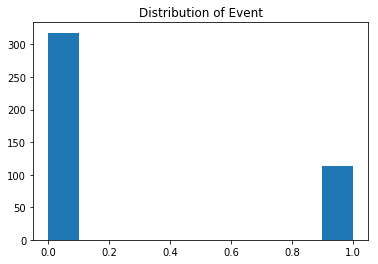

In [7]:
plt.hist(event_data)
plt.title('Distribution of Event')
plt.show()

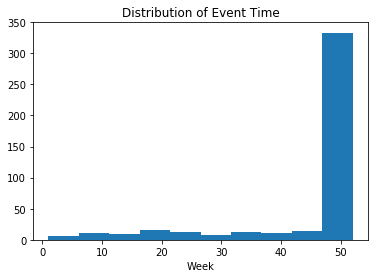

In [8]:
plt.hist(dtime_data)
plt.title('Distribution of Event Time')
plt.xlabel('Week')
plt.show()

Let the time start with 0.

In [9]:
dtime_data2 = np.int32(dtime_data - 1)

maxtime = np.max(dtime_data2) + 1
maxtime

52

Check the number of unique values for each column.

In [10]:
for col in df.columns:
  print(col, df[col].value_counts().shape[0])

fin 2
age 28
race 2
wexp 2
mar 2
paro 2
prio 17


In [11]:
X_data = np.repeat(np.array(df)[:, None, :], maxtime, axis=1)
X_data.shape

(432, 52, 7)

Split train and test set.

In [12]:
hazard_mask = np.zeros([X_data.shape[0], maxtime])
hazard_mask[event_data==1, dtime_data2[event_data==1]] = 1.
survival_mask = np.zeros([X_data.shape[0], maxtime])
for i in range(X_data.shape[0]):
  survival_mask[i,:dtime_data2[i]+1] = 1.

X_train, X_test, hazard_mask_train, hazard_mask_test, survival_mask_train, survival_mask_test = train_test_split(X_data, hazard_mask, survival_mask, stratify=np.sum(hazard_mask, 1), test_size=0.2, random_state=2019)

print(X_train.shape)
print(hazard_mask_train.shape)
print(survival_mask_train.shape)

print(X_test.shape)
print(hazard_mask_test.shape)
print(survival_mask_test.shape)

(345, 52, 7)
(345, 52)
(345, 52)
(87, 52, 7)
(87, 52)
(87, 52)


Check if the stratification is well applied.

In [13]:
print(np.unique(np.sum(hazard_mask_train, 1), return_counts=True))
print(np.unique(np.sum(hazard_mask_test, 1), return_counts=True))

(array([0., 1.]), array([254,  91]))
(array([0., 1.]), array([64, 23]))


Normalize the varibales.

In [14]:
X_train_concat = X_train.reshape([-1, X_train.shape[2]])
X_test_concat = X_test.reshape([-1, X_test.shape[2]])

train_mean = X_train_concat.mean(0)
train_std = X_train_concat.std(0)

X_train_norm = (X_train_concat - train_mean)/train_std
X_test_norm = (X_test_concat - train_mean)/train_std

X_train_norm = np.where(np.isnan(X_train_norm), 0., X_train_norm)
X_test_norm = np.where(np.isnan(X_test_norm), 0., X_test_norm)

X_train_norm = X_train_norm.reshape([-1, maxtime, X_train.shape[2]])
X_test_norm = X_test_norm.reshape([-1, maxtime, X_test.shape[2]])

X_train_norm[0:10,0,:]

array([[-0.98561076,  1.15983999,  0.37230883,  0.86675777,  2.6501426 ,
         0.78722189, -0.35472611],
       [ 1.01459931,  0.83933955,  0.37230883, -1.15372487, -0.37733819,
        -1.27028987, -0.68909908],
       [ 1.01459931,  2.44184173,  0.37230883,  0.86675777, -0.37733819,
         0.78722189, -0.35472611],
       [-0.98561076,  0.83933955,  0.37230883,  0.86675777, -0.37733819,
         0.78722189, -0.02035314],
       [-0.98561076,  0.51883911,  0.37230883,  0.86675777,  2.6501426 ,
         0.78722189, -0.68909908],
       [-0.98561076,  0.51883911, -2.68594224,  0.86675777,  2.6501426 ,
         0.78722189,  0.31401984],
       [-0.98561076,  0.67908933,  0.37230883, -1.15372487, -0.37733819,
        -1.27028987,  0.31401984],
       [ 1.01459931, -0.92341285,  0.37230883, -1.15372487, -0.37733819,
         0.78722189, -0.35472611],
       [ 1.01459931,  1.3200902 ,  0.37230883,  0.86675777,  2.6501426 ,
        -1.27028987,  1.9858847 ],
       [-0.98561076,  0.3585

## 4. Construct the Network

In [0]:
state_size = 16

In [16]:
input_cov = tf.keras.Input((maxtime, X_train_norm.shape[2]))

h = tf.keras.layers.LSTM(state_size, return_sequences=True)(input_cov)
h = tf.keras.layers.LSTM(state_size, return_sequences=True)(h)

lamb = tf.keras.layers.Dense(1, activation='sigmoid', 
                             kernel_regularizer=tf.keras.regularizers.l1_l2(0, 1.e-3))(h)
lamb = tf.keras.layers.ActivityRegularization(l1=0, l2=1.e-2)(lamb)
lamb = tf.keras.layers.Flatten()(lamb)

model = tf.keras.Model(input_cov, lamb)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 52, 7)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 52, 16)            1536      
_________________________________________________________________
lstm_1 (LSTM)                (None, 52, 16)            2112      
_________________________________________________________________
dense (Dense)                (None, 52, 1)             17        
_________________________________________________________________
activity_regularization (Act (None, 52, 1)             0         
_________________________________________________________________
flatten (Flatten)            (None, 52)                0         
Total params: 3,665
Trainable params: 3,665
Non-trainable params: 0
___________________________________________________________

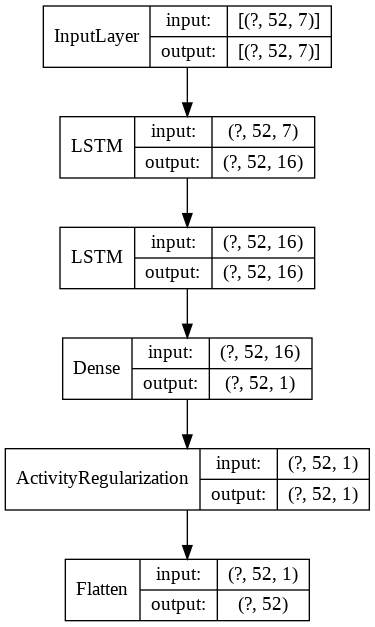

In [27]:
tf.keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

Define likelihood loss function.

In [0]:
def custom_loss(beta=1., eps=1.e-12):
  def likelihood_loss(y_true, y_pred):
    #hazard_series = -tf.math.log(1. + tf.exp(-y_pred)) # log(sigmoid(y_pred))
    #survival_series = -y_pred-tf.math.log(1. + tf.exp(-y_pred)) # log(1-sigmoid(y_pred))
    hazard_series = tf.math.log(y_pred + eps)
    survival_series = tf.math.log(1. - y_pred + eps)
    eventrate_series = 1. - y_pred

    event = tf.cast(tf.reduce_sum(hazard_mask_train, axis=1), dtype=tf.float32)
    
    loghazard = tf.reduce_sum(hazard_series * hazard_mask_train, axis=1)
    logsurvival = tf.reduce_sum(survival_series * survival_mask_train, axis=1)

    loss_z = -tf.reduce_mean(loghazard + tf.reduce_sum(survival_series * (survival_mask_train - hazard_mask_train), axis=1)*event)
    loss_c = -tf.reduce_mean(event*tf.math.log(1.-tf.exp(logsurvival)+eps) + (1-event)*logsurvival)

    return loss_z + beta*loss_c
  
#  def likelihood_loss(y_true, y_pred):
#    hazard_series = tf.math.log(y_pred + eps)
#    survival_series = tf.math.log(1. - y_pred + eps)
#    
#    loghazard = tf.reduce_sum(hazard_series * hazard_mask_train, axis=1)
#    logsurvival = tf.reduce_sum(survival_series * (survival_mask_train - hazard_mask_train), axis=1)
#
#    loss = -tf.reduce_mean(loghazard + logsurvival)
#
#    return loss
  
  return likelihood_loss

In [0]:
model.compile(
    #optimizer=tf.keras.optimizers.Nadam(1e-4, clipnorm=1.),
    optimizer=RAdamOptimizer(1e-3),
    loss=custom_loss(.5),
)

Train.

In [0]:
history = model.fit(
    x = X_train_norm,
    y = np.zeros_like(hazard_mask_train), # dummy variable
    verbose = 0,
    batch_size = X_train.shape[0], # full batch
    epochs = int(1e6),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, restore_best_weights=True)]
)

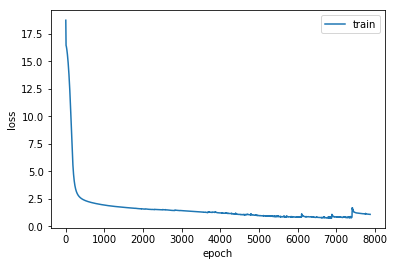

In [21]:
  plt.plot(history.history['loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper right')
  plt.show()

## 5. Results

In [0]:
hazard_train = model.predict(X_train_norm)
survival_train = np.cumprod(1 - hazard_train, axis=1)

hazard_test = model.predict(X_test_norm)
survival_test = np.cumprod(1 - hazard_test, axis=1)

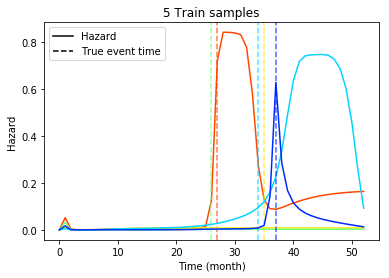

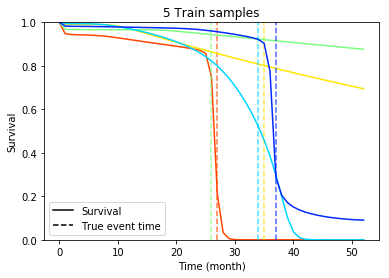

In [23]:
num_sample = 5
color = sns.color_palette('jet_r', num_sample)

dtime_train = survival_mask_train.sum(1)
event_train = np.floor(hazard_mask_train.sum(1))

custom_lines = [Line2D([0], [0], color='k'),
                Line2D([0], [0], color='k', linestyle='--')]

for i in range(num_sample):
  plt.plot(np.linspace(0, maxtime, maxtime+1), np.append(0, hazard_train[event_train==1][i]), color=color[i])
  plt.axvline(dtime_train[event_train==1][i], color=color[i], linestyle='--', alpha = 0.7)
plt.ylabel('Hazard')
plt.xlabel('Time (month)')
plt.title(str(num_sample)+' Train samples')
plt.legend(custom_lines, ('Hazard', 'True event time'))
plt.show()

for i in range(num_sample):
  plt.plot(np.linspace(0, maxtime, maxtime+1), np.append(1, survival_train[event_train==1][i]), color=color[i])
  plt.axvline(dtime_train[event_train==1][i], color=color[i], linestyle='--', alpha = 0.7)
plt.ylabel('Survival')
plt.xlabel('Time (month)')
plt.title(str(num_sample)+' Train samples')
plt.ylim([0, 1])
plt.legend(custom_lines, ('Survival', 'True event time'))
plt.show()

Where dotted lines indicate true event times.

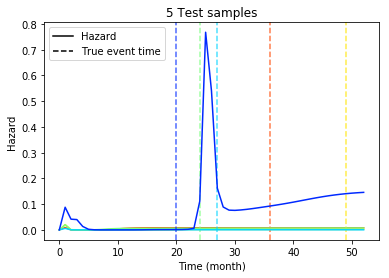

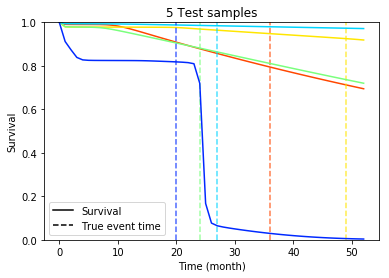

In [24]:
num_sample = 5
color = sns.color_palette('jet_r', num_sample)

dtime_test = survival_mask_test.sum(1)
event_test = np.floor(hazard_mask_test.sum(1))

for i in range(num_sample):
  plt.plot(np.linspace(0, maxtime, maxtime+1), np.append(0, hazard_test[event_test==1][i]), color=color[i])
  plt.axvline(dtime_test[event_test==1][i], color=color[i], linestyle='--', alpha = 0.7)
plt.ylabel('Hazard')
plt.xlabel('Time (month)')
plt.title(str(num_sample)+' Test samples')
plt.legend(custom_lines, ('Hazard', 'True event time'))
plt.show()

for i in range(num_sample):
  plt.plot(np.linspace(0, maxtime, maxtime+1), np.append(1, survival_test[event_test==1][i]), color=color[i])
  plt.axvline(dtime_test[event_test==1][i], color=color[i], linestyle='--', alpha = 0.7)
plt.ylabel('Survival')
plt.xlabel('Time (month)')
plt.title(str(num_sample)+' Test samples')
plt.ylim([0, 1])
plt.legend(custom_lines, ('Survival', 'True event time'))
plt.show()

Evaluate the time-dependent concordance index $C^{td}$, where
\begin{align}
C^{td}=Pr\left[ \hat{F}(s^{(i)}|x^{(i)}) > \hat{F}(s^{(i)}|x^{(j)}) | s^{(i)} < s^{(j)} \right],
\end{align}
which is derived from comparison of pairs in which one patient has experienced the event at a particular time while the other has been censored by that time.

In [0]:
def ctd(truetime, predsurv_mat, indicator):
    N = truetime.shape[0]

    truetime = np.int32(truetime.reshape([-1,]))
    
    comparable = 0.
    concordance = 0.

    for i in range(N):
        if indicator[i] == 0:
            continue
        for j in range(N):
            if indicator[j] == 1:
                if truetime[i] < truetime[j]:
                    comparable += 1.
                    if predsurv_mat[i,truetime[i]] < predsurv_mat[j,truetime[i]]:
                        concordance += 1.
                    elif predsurv_mat[i,truetime[i]] == predsurv_mat[j,truetime[i]]:
                        concordance += .5
            else:
                if truetime[i] <= truetime[j]:
                    comparable += 1.
                    if predsurv_mat[i,truetime[i]] < predsurv_mat[j,truetime[i]]:
                        concordance += 1.
                    elif predsurv_mat[i,truetime[i]] == predsurv_mat[j,truetime[i]]:
                        concordance += .5
    return concordance / comparable

In [26]:
print('Train Ctd: \t' + f'{ctd(np.sum(survival_mask_train, 1, keepdims=True)-1, survival_train, np.sum(hazard_mask_train, 1, keepdims=True)):.3f}')
print('Test Ctd: \t' + f'{ctd(np.sum(survival_mask_test, 1, keepdims=True)-1, survival_test, np.sum(hazard_mask_test, 1, keepdims=True)):.3f}')

Train Ctd: 	0.920
Test Ctd: 	0.535


There exists overfitting.